# Downscaling EDA

This notebook is for exploring CMIP6 statistical downscaling options. 


## QPLAD

The "QPLAD" method of statistical downscaling, introduced in [Gergel et al. 2023](https://doi.org/10.5194/gmd-17-191-2024),  is of interest to collaborators. This section will explore implementing it. 

The code used to do it is in a fork of the `xclim` package developed by the team who created this method: [https://github.com/ClimateImpactLab/xclim](https://github.com/ClimateImpactLab/xclim). 

The [ClimateImpactLab/dodola](https://github.com/ClimateImpactLab/dodola) repo contains the python code used to actually perform the downscaling. 

### Environment

This is an experimental notebook, and will use their forked version of xclim. To do so, create a conda env from the `environment.yml` file in that repo, and then install the repo using pip:

```
# can rename the env in the yml file
conda env create -f environment.yml
conda activate <env_name>
pip install git+https://github.com/ClimateImpactLab/xclim@master
```

### Standardizing simulation and reference data 

Here we will explore preparing the data by standardizing it. 

Let's start with the reference data. 

The Gergel methods perform 3 separate regriddings of the ERA5 data:

1. For QDM adjustment, it's regridded to the common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. For downscaling with QPLAD, it is regridded to a 0.25° × 0.25° regular lat–long grid
3. For QPLAD adjustment factors, common grid ERA5 is resampled (nearest neighbor regridded) to the 0.25° × 0.25° regular lat–long grid


The target grid for now will be 12km in EPSG:3338. So here's what our methods will be for regridding ERA5:

1. Regrid to common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. Regrid to target 12km 3338 grid
3. Resample common grid ERA5 via NN to target 12km 3338 grid

### Setup

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import geopandas as gpd
from wrf import PolarStereographic
from pyproj import CRS, Transformer, Proj
import xesmf as xe

### Add projection info to WRF dataset

First we need to project the wrf dataset, i.e. add the coordinate info

In [2]:
era5_12km_dir = Path("/beegfs/CMIP6/wrf_era5/12km")

fp = era5_12km_dir.joinpath("2015/era5_wrf_dscale_12km_2015-12-26.nc")
ds = xr.open_dataset(fp)

### 1. Regrid ERA5 to common grid

We will use xESMF to regrid from the WRF grid to the regular lat-long grid. Since the WRF file already has lat / lon, we can use it as-is.

Load a comming grid CMIP6 file:

In [3]:
regrid_fp = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/Amon/tas/tas_Amon_GFDL-ESM4_historical_regrid_195001-195012.nc"
)

dst_ds = xr.open_dataset(regrid_fp)

And regrid from native ERA5 grid to common CMIP6 grid:

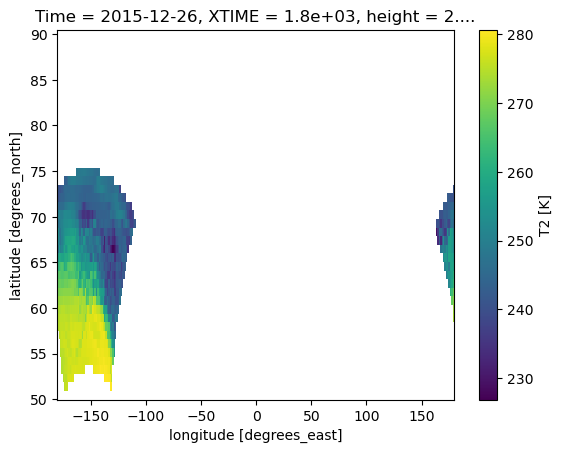

In [140]:
tmp_da = ds["T2"].rename({"XLONG": "lon", "XLAT": "lat"})
regridder = xe.Regridder(tmp_da, dst_ds, "bilinear", unmapped_to_nan=True)
regrid = regridder(tmp_da, keep_attrs=True)
regrid.isel(Time=0).plot()

### 2. Regrid ERA5 to target grid

We don't have a target grid defined at the moment, so we will make one! We can just use rioxarray to quickly reproject from the stereographic WRF projection to EPSG:3338. Rioxarray is assuredly choosing sane defaults... :)

To do this reprojection, we will load the ancillary "geogrid" file from WRF and compute the grid coordinates by transforming the grid center lat / lon and using the grid shape and pixel size to construct the coordinates.

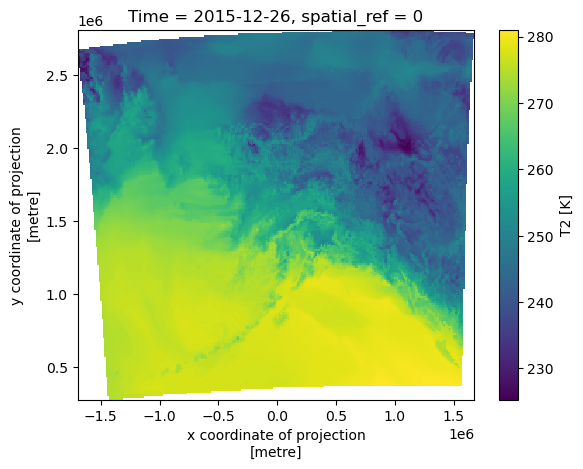

In [139]:
geo_ds1 = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d01.nc")
geo_ds1.attrs["CEN_LON"]

# we only need these two attributes to reconstruct the projection
wrf_proj = PolarStereographic(
    **{"TRUELAT1": geo_ds1.attrs["TRUELAT1"], "STAND_LON": geo_ds1.attrs["STAND_LON"]}
).proj4()
# WGS84 projection
wgs_proj = Proj(proj="latlong", datum="WGS84")
wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# this is where we plug in the center longitude of the domain to get the center x, y in projected space
e, n = wgs_to_wrf_transformer.transform(
    geo_ds1.attrs["CEN_LON"], geo_ds1.attrs["TRUELAT1"]
)
# now compute the rest of the grid based on x/y dimension lengths and grid spacing
dx = dy = 12000
nx = ds.XLONG.shape[1]
ny = ds.XLONG.shape[0]
x0 = -(nx - 1) / 2.0 * dx + e
y0 = -(ny - 1) / 2.0 * dy + n
# 2d grid coordinate values
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

wrf_crs = CRS.from_proj4(wrf_proj)
ds_proj = (
    ds["T2"]
    .rename({"south_north": "y", "west_east": "x"})
    .assign_coords({"y": ("y", y), "x": ("x", x)})
    .drop_vars(["XLONG", "XLAT", "XTIME"])
    .rio.set_spatial_dims("x", "y")
    .to_dataset()
    .rio.write_crs(wrf_crs)
)

ds_3338 = ds_proj.rio.reproject("EPSG:3338")
ds_3338.isel(Time=0).T2.plot()

We will probably want a cropped version of this for our target grid, so that we don't have any empty pixels.

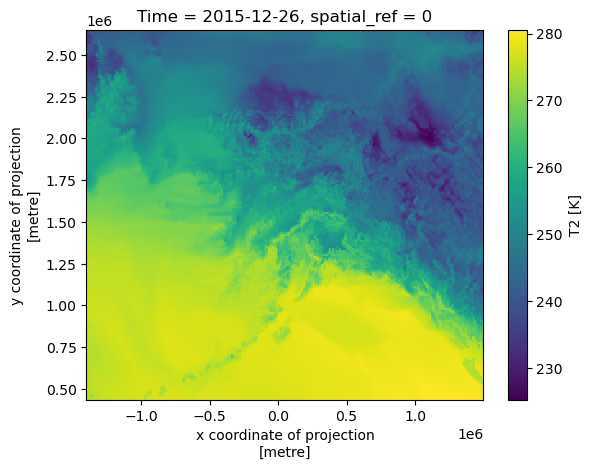

In [133]:
# we will go a little bit inside of minimum recangular domain which conatins only
#  nodata values so that we can use it for regridding the common grid ERA5 data
ds_3338_cropped = ds_3338.sel(x=slice(-1.4e6, 1.5e6), y=slice(2.65e6, 4.35e5))
ds_3338_cropped.isel(Time=0).T2.plot()

### 3. Resample common grid ERA5 via NN to target 12km 3338 grid

Now that we have our common grid ERA5 as well as ERA5 on our target grid, we can use both to resample the common grid ERA5 to the target grid to get the third product, which is needed for the downscaling. 

In [141]:
# following gergel et al, this ERA5 data on the target grid is called the "fine" version.
era5_fine = ds_3338_cropped.T2

# wow copilot pretty much nailed it here
# BEGIN: Add irregular lat and lon variables
# Create a transformer from the WRF projection to WGS84
transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(era5_fine["x"].values, era5_fine["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
era5_fine = era5_fine.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

Do the regridding:

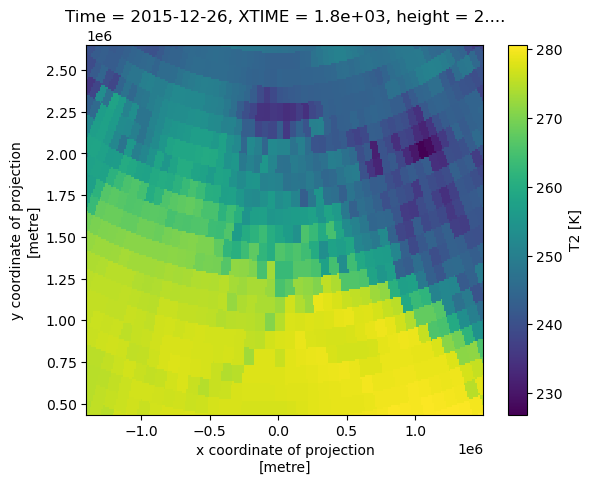

In [142]:
era5_coarse_regridder = xe.Regridder(
    regrid, era5_fine, "nearest_s2d", unmapped_to_nan=True
)
era5_coarse = era5_coarse_regridder(regrid, keep_attrs=True)
era5_coarse.isel(Time=0).plot()